In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
from PIL import Image

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define batch size
batch_size = 4

# Define the classes
classes = ('cat', 'car', 'frog', 'other')

# Define a function to map original labels to new labels
def map_labels(label):
    if label == 3:
        return 0  # cat
    elif label == 1:
        return 1  # car
    elif label == 6:
        return 2  # frog
    else:
        return 3  # other

# Define custom dataset class to map labels
class CustomCIFAR10(torchvision.datasets.CIFAR10):
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # Convert image and target to PIL Image and label
        img = Image.fromarray(img)

        # Map the target to new label
        target = map_labels(target)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

# Load the CIFAR-10 dataset with custom mapping
trainset = CustomCIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = CustomCIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:04<00:00, 39526368.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


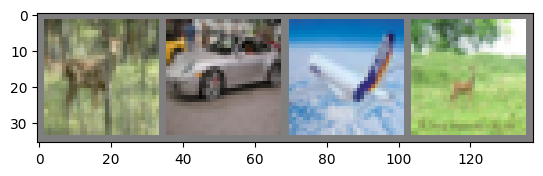

other car   other other


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Define imshow function to visualize images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5,padding=2)
        self.fc1 = nn.Linear(64 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

  0%|          | 0/4 [00:00<?, ?it/s]

[1,  2000] loss: 0.930
[1,  4000] loss: 0.891
[1,  6000] loss: 0.862
[1,  8000] loss: 0.844
[1, 10000] loss: 0.802
[1, 12000] loss: 0.773


 25%|██▌       | 1/4 [02:03<06:09, 123.10s/it]

[2,  2000] loss: 0.721
[2,  4000] loss: 0.645
[2,  6000] loss: 0.626
[2,  8000] loss: 0.583
[2, 10000] loss: 0.570
[2, 12000] loss: 0.552


 50%|█████     | 2/4 [04:01<04:00, 120.33s/it]

[3,  2000] loss: 0.516
[3,  4000] loss: 0.505
[3,  6000] loss: 0.503
[3,  8000] loss: 0.511
[3, 10000] loss: 0.493
[3, 12000] loss: 0.496


 75%|███████▌  | 3/4 [05:58<01:59, 119.03s/it]

[4,  2000] loss: 0.440
[4,  4000] loss: 0.441
[4,  6000] loss: 0.457
[4,  8000] loss: 0.442
[4, 10000] loss: 0.447
[4, 12000] loss: 0.447


100%|██████████| 4/4 [08:00<00:00, 120.01s/it]


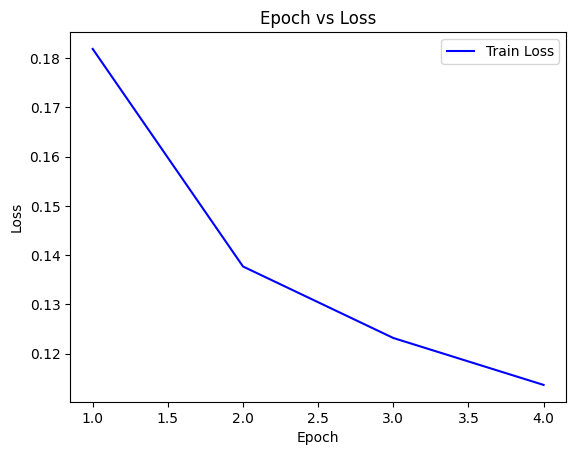

Finished Training


In [6]:
train_epoch_losses = []
for epoch in tqdm(range(4)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    train_epoch_losses.append(running_loss/2000)


# Plot the loss over epochs
plt.plot(range(1, 5), train_epoch_losses, color='blue', label='Train Loss')
# plt.plot(range(1, 5), test_epoch_losses, color='red', label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

print('Finished Training')

In [7]:
PATH = 'cifar_net3.pth'
torch.save(net.state_dict(), PATH)

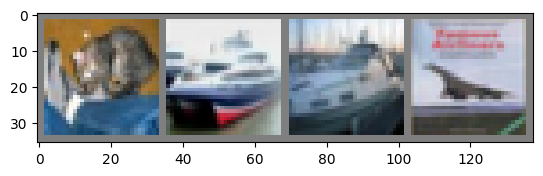

GroundTruth:  cat   other other other


In [8]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [9]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [10]:
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   car   other other


In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 82 %


Accuracy for class: cat   is 35.3 %
Accuracy for class: car   is 69.4 %
Accuracy for class: frog  is 81.6 %
Accuracy for class: other is 91.9 %
Average Loss for the epoch: 0.4562


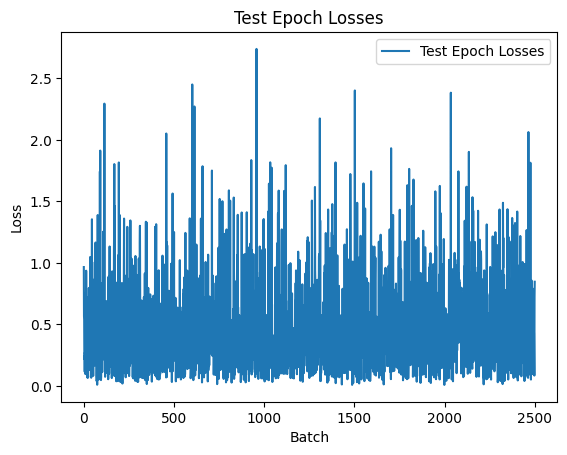

In [13]:
# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
test_epoch_losses = []

# Again, no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # Compute the loss for the batch
        loss = criterion(outputs, labels)
        test_epoch_losses.append(loss.item())

        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Print average loss for the epoch
average_loss = sum(test_epoch_losses) / len(test_epoch_losses)
print(f'Average Loss for the epoch: {average_loss:.4f}')

# Plot test epoch losses
plt.plot(test_epoch_losses, label='Test Epoch Losses')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Test Epoch Losses')
plt.legend()
plt.show()

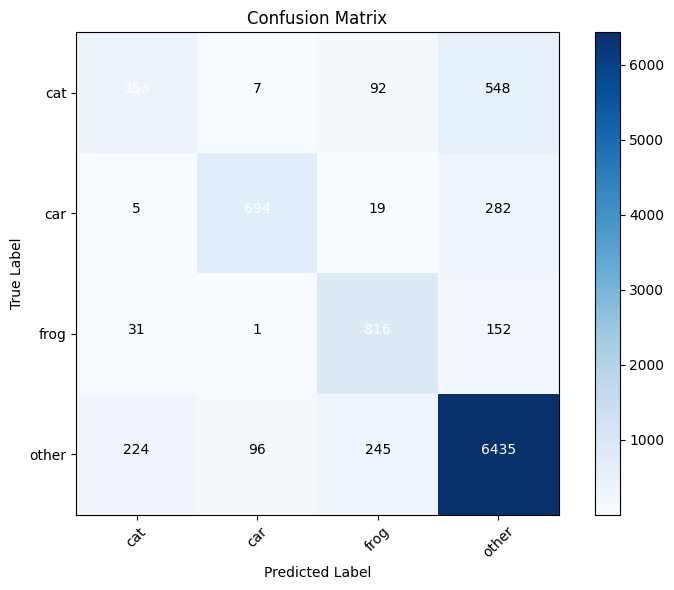

In [14]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
class_names = classes

# Store predictions and labels for confusion matrix
all_predictions = []
all_labels = []

# Again, no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # Collect predictions and labels
        all_predictions.extend(predictions.tolist())
        all_labels.extend(labels.tolist())

        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix with annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)

# Add annotations (numbers) to each block of the confusion matrix
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', color='white' if i == j else 'black')

plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()
